# Naive object classification

### Imports necessary modules and image inspection

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = 'images/details.png'

How does the raw image look like?

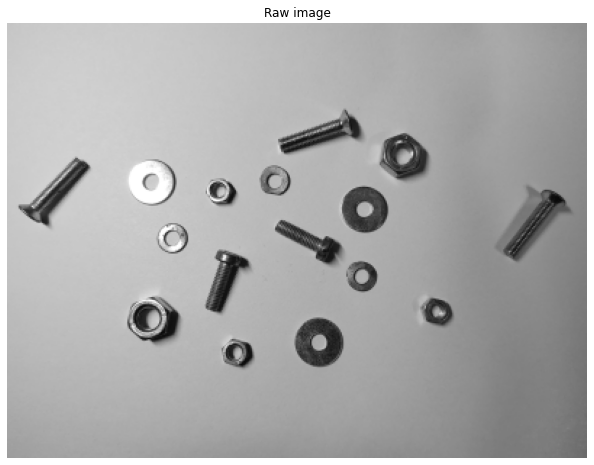

In [36]:
raw_img = cv2.imread(img_path)
plt.figure(figsize=(12, 8))
plt.imshow(raw_img, cmap='gray')
plt.axis('off')
plt.title("Raw image")
plt.show()

### Image preprocessing and binarization
Given that the raw image is unevenly illuminated the first steps of my analysis include some morphological operations and histogram equalization.
When successfully applied binarization will allow us to separate objects for connected component processing.

In [37]:
def preprocessing_and_binarization(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    X, Y = img_gray.shape
    for i in range(X):
        for j in range(Y):
            if img_gray[i,j] > 220:
                img_gray[i,j] -= 100


    dilated_img = cv2.dilate(img_gray, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = cv2.absdiff(img_gray, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

    plt.figure(figsize=(12, 8))
    plt.imshow(norm_img, 'gray')
    plt.axis("off")
    plt.title('Image morphology and histogram equalization')
    plt.show()

    _, binarized = cv2.threshold(norm_img, 0, 255, cv2.THRESH_OTSU)
    _, small_binarize = cv2.threshold(norm_img[90:160, 80:125], 0, 255, cv2.THRESH_OTSU)

    binarized[90:160, 80:125] = cv2.morphologyEx(small_binarize, cv2.MORPH_CLOSE, np.ones((3,3), dtype=np.uint8))
    binarized[95:120,170:205] = cv2.morphologyEx(binarized[95:120,170:205], cv2.MORPH_CLOSE, np.ones((5,5), dtype=np.uint8))


    plt.figure(figsize=(12, 8))
    plt.imshow(binarized, 'gray')
    plt.axis("off")
    plt.title('Binarization')
    plt.show()

    return img, img_gray, binarized


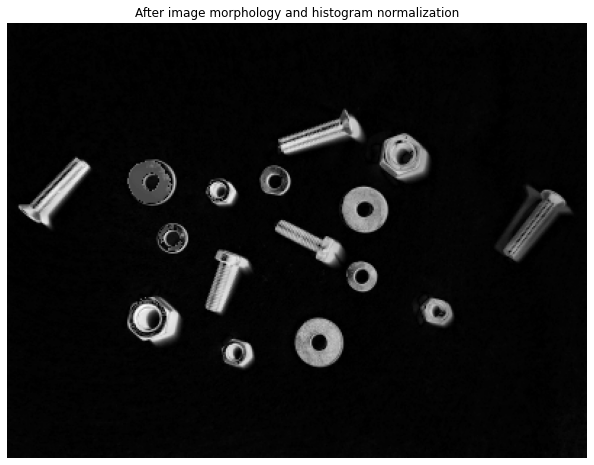

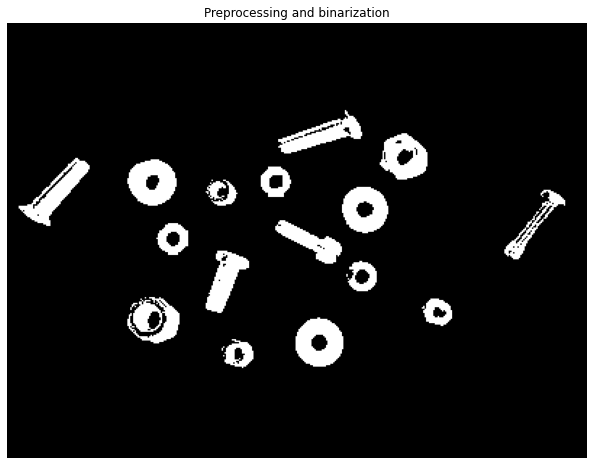

In [38]:
img, img_gray, binarized = preprocessing_and_binarization(img_path)

### Connected component labelling and indexation
This step takes advantage of Hu's invariant moments of given components in the binarized image. We want to recognize bolts, nuts and covers in the image.

In [39]:
def indexation(img, img_gray, binarized):
    bolts = np.zeros(img_gray.shape)
    covers = np.zeros(img_gray.shape)
    nuts = np.zeros(img_gray.shape)
    ccl_vis = img.copy()
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(binarized)
    matrix = np.zeros((7,retval-7))
    n = 0
    for s in range(1, retval):
        if np.sum((labels ==s)*1) > 20:
            cv2.putText(ccl_vis,str(s-n),(int(centroids[s,0]),int(centroids[s,1])),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
            I_shape = (labels == s)*1
            I_shape = I_shape.astype('uint8')
            moments = cv2.moments(I_shape)
            HU = cv2.HuMoments(moments)
            matrix[:,s-1-n] = HU.reshape(7,)
            if HU[0,0] > 0.282:
                bolts += I_shape
                bolts = bolts.astype('uint8')
            if -1.65e-08 < HU[4, 0] < 4.54e-14:
                covers += I_shape
                covers = covers.astype('uint8')
            if 0.206 < HU[0, 0] < 0.2693 and 0.0005 < HU[1, 0] < 0.0043 and HU[4, 0] > 4.55e-14:
                nuts += I_shape
                nuts = nuts.astype('uint8')
        else:
            n += 1

    fig, ax = plt.subplots(2, 2, figsize=(20, 12))
    ax = ax.flatten()

    titles = ['Bolts', 'Covers', 'Nuts', 'Indexed']
    imgs = [bolts, covers, nuts, ccl_vis]

    for i, (img, title) in enumerate(zip(imgs, titles)):
        ax[i].imshow(img, 'gray')
        ax[i].axis('off')
        ax[i].set_title(title)

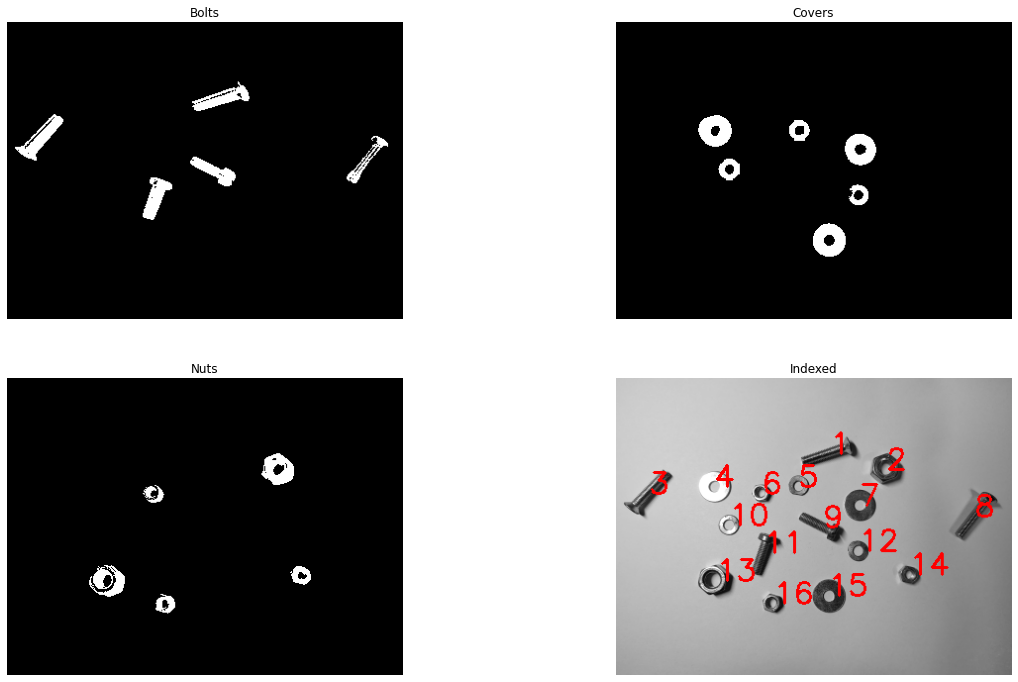

In [40]:
indexation(img, img_gray, binarized)

### Conclusions
The classification was successful, but included a lot of manual work and value checks. Nonetheless it shows how one can classify various elements in a real life image with pretty simple computer vision techniques. It's a great ground work for feature extraction in general image processing.